<a href="https://www.kaggle.com/code/kapturovalexander/kapturov-s-titanic-ml-from-disaster?scriptVersionId=205176208" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <span style="background-image: url(https://www.kaggle.com/competitions/3136/images/header); color: #BDD5DD">Titanic - Machine Learning from Disaster

![](https://www.kaggle.com/competitions/3136/images/header)

![](https://gcaptain.com/wp-content/uploads/2016/04/Titanicpaint.jpg)

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

The Titanic dataset is used to perform binary classification: using information about a passenger, predict whether the passenger will survive or not. The dataset features are as follows:

- **PassengerId** - passenger ID
- **Pclass** - ticket service class (1 = first, 2 = second, 3 = third)
- **Name** - passenger name
- **Sex** - passenger gender
- **Age** - passenger age
- **SibSp** - sibling/spouse family relationships (sibling = brother, sister, half-brother, half-sister, spouse = husband, wife)
- **Parch** - parent/child family relationships (parent = parent
child = child). Some children traveled only with a nanny, so for them parch=0.
- **Ticket** - ticket number
- **Fare** - ticket price
- **Cabin** - cabin number
- **Embarked** - Embarkation port. (C = Cherbourg, Q = Queenstown, S = Southampton)

Target variable:
- <font color='blue'>**Survived**</font> - Whether the person survived or not. 0 = No, 1 = Yes.

# <span style="color: #03adfc; border-bottom: 6px solid #BDD5DD; background-color: #4d0099;">🛳️ Import libraries</span>

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# <span style="color: #03adfc; border-bottom: 6px solid #BDD5DD; background-color: #4d0099;">🧊 Load the training and test set</span>

In [3]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [4]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train.Ticket.values[:30]

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649', '239865', '248698', '330923', '113788',
       '349909', '347077', '2631', '19950', '330959', '349216'],
      dtype=object)

### Ticket feature is useless. Name feature also doesn't have valuable information

In [7]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

# <span style="color: #03adfc; border-bottom: 6px solid #BDD5DD; background-color: #4d0099;">😭 Display histograms of distribution</span>

In [8]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
train.describe(include=['object', 'bool'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


# Pivot tables

In [10]:
pd.crosstab(index=train['Survived'], columns=train['Pclass'])

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


In [11]:
pd.crosstab(index=train['Survived'], columns=train['Pclass'], normalize=True)

Pclass,1,2,3
Survived,,,
0,0.089787,0.108866,0.417508
1,0.152637,0.097643,0.133558


In [12]:
pd.pivot_table(data=train, values='Survived', index='Pclass', columns='Sex', aggfunc='count')

Sex,female,male
Pclass,,
1,94,122
2,76,108
3,144,347


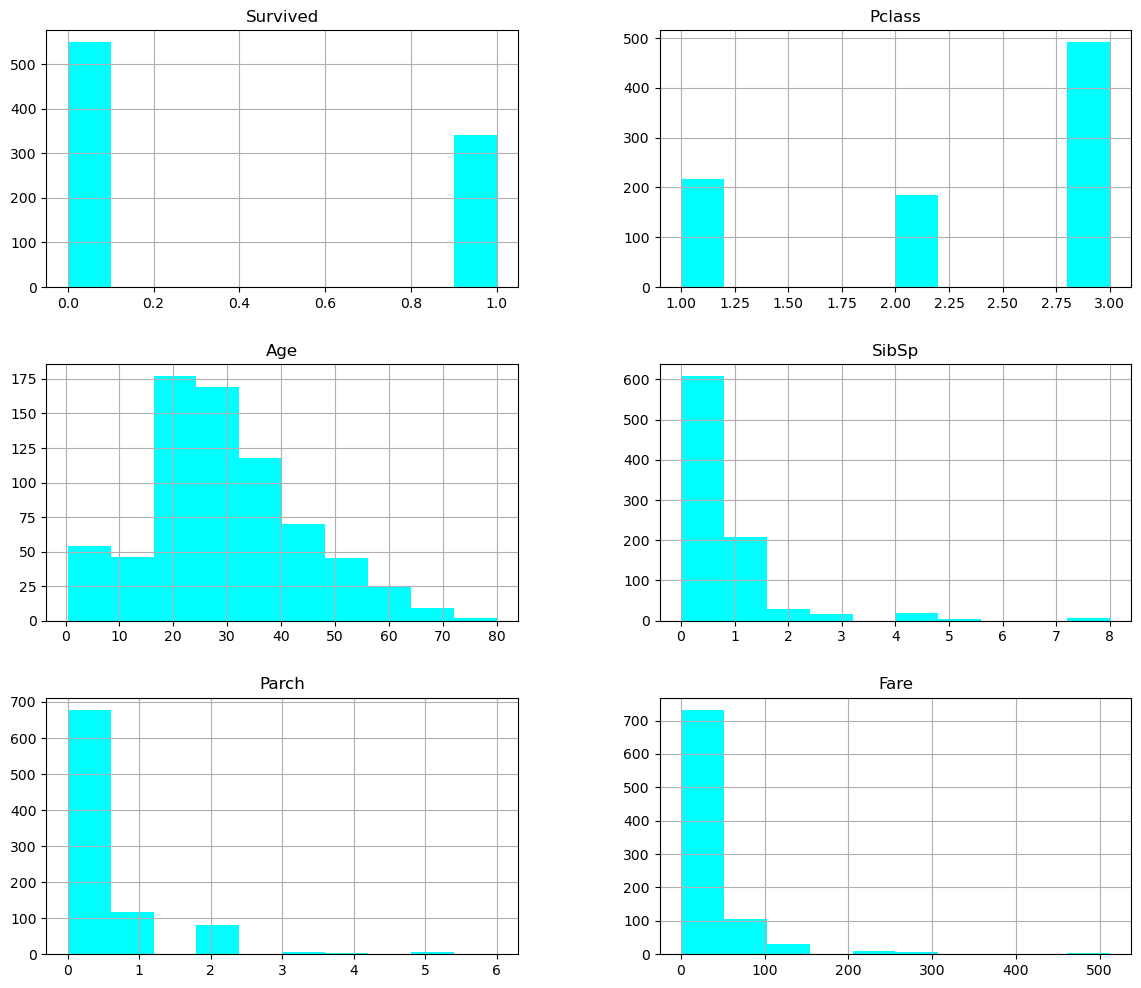

In [13]:
train.drop('PassengerId', axis=1).hist(figsize=(14, 12), color='aqua');

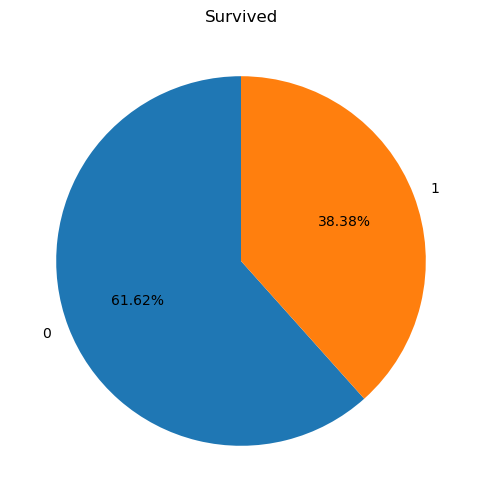

In [14]:
survived_label_counts = train.Survived.value_counts()

plt.figure(figsize=(12, 6))
plt.pie(x=survived_label_counts, labels=survived_label_counts.index, autopct='%1.2f%%', startangle=90)
plt.title('Survived')
plt.show()

### Just few than 40% survived

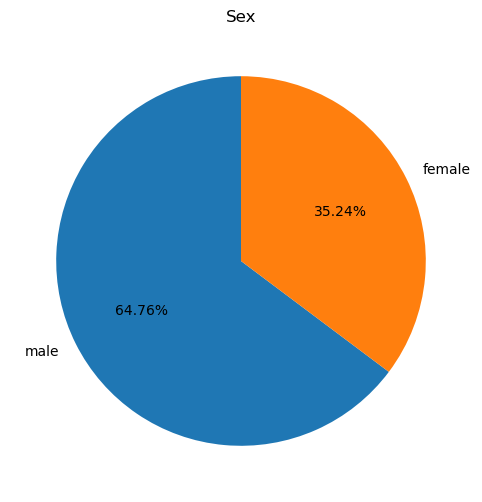

In [15]:
sex_label_counts = train.Sex.value_counts()

plt.figure(figsize=(12, 6))
plt.pie(x=sex_label_counts, labels=sex_label_counts.index, autopct='%1.2f%%', startangle=90)
plt.title('Sex')
plt.show()

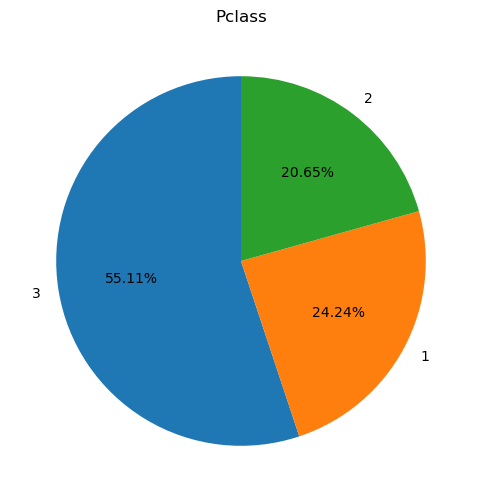

In [16]:
pclass_label_counts = train.Pclass.value_counts()

plt.figure(figsize=(12, 6))
plt.pie(x=pclass_label_counts, labels=pclass_label_counts.index, autopct='%1.2f%%', startangle=90)
plt.title('Pclass')
plt.show()

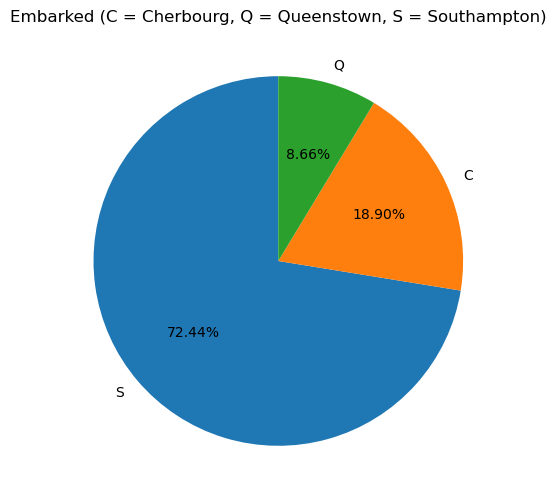

In [17]:
embarked_label_counts = train.Embarked.value_counts()

plt.figure(figsize=(12, 6))
plt.pie(x=embarked_label_counts, labels=embarked_label_counts.index, autopct='%1.2f%%', startangle=90)
plt.title('Embarked (C = Cherbourg, Q = Queenstown, S = Southampton)')
plt.show()

In [18]:
train.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

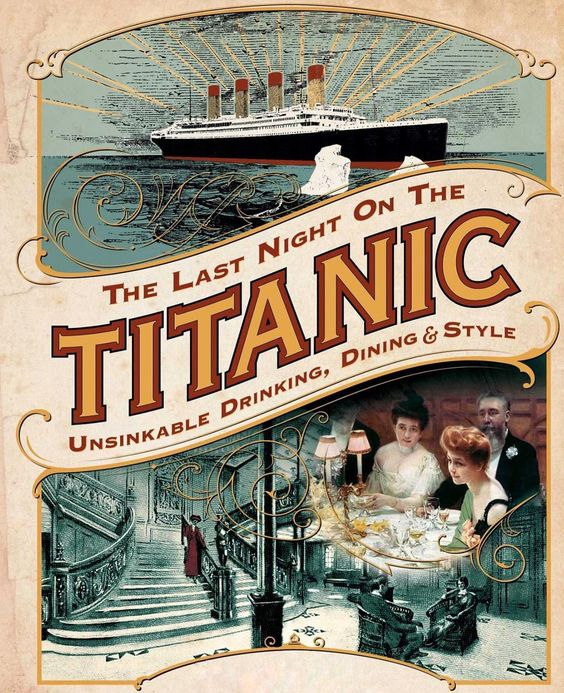

## <span style="color: red">Women are in two times less than Men

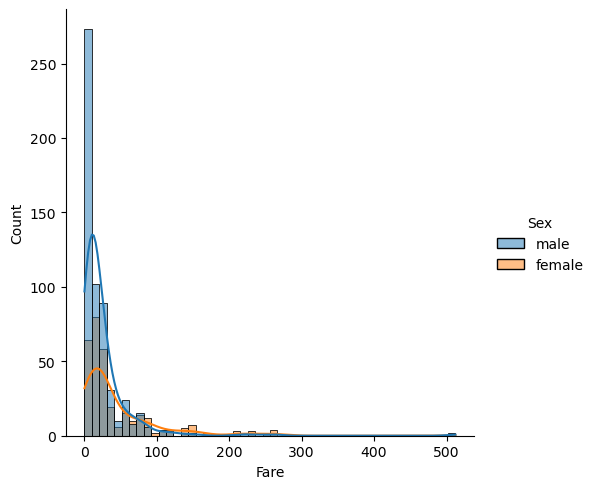

In [19]:
sns.displot(data=train, x='Fare', hue='Sex', bins=50, color='red', kde=True);

## <span style="color: red">Most tickets costed less than 30$

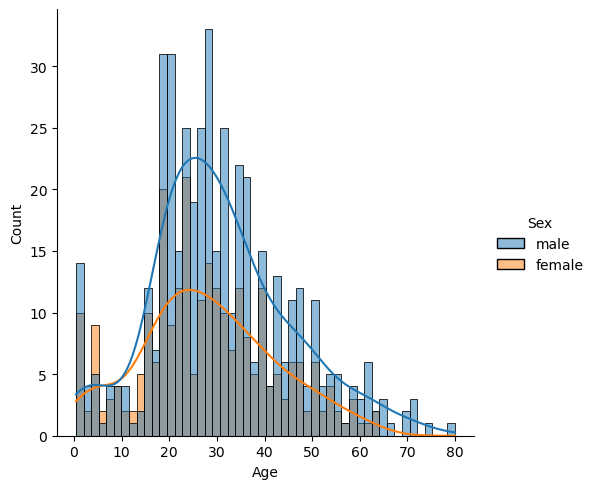

In [20]:
sns.displot(data=train, x='Age', hue='Sex', bins=50, color='orange', kde=True);

## <span style="color: red">Average age for women between 20 and 30, for men between 20 and 40

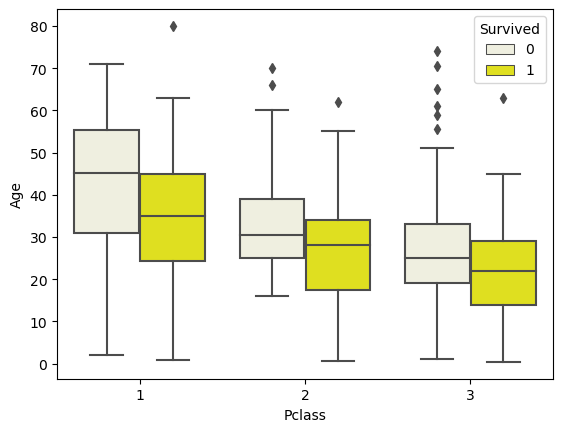

In [21]:
sns.boxplot(data=train, x="Pclass", y="Age", hue="Survived", color='yellow');

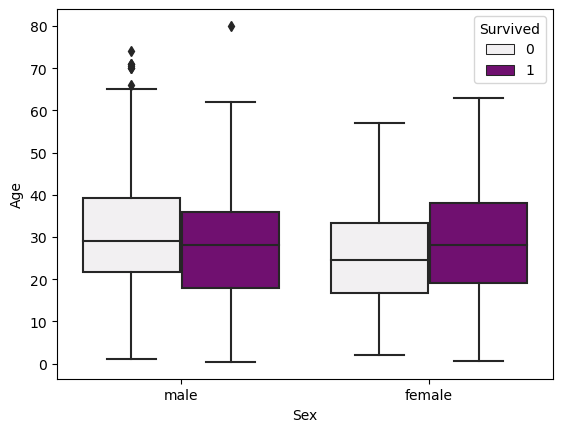

In [22]:
sns.boxplot(data=train, x="Sex", y="Age", hue="Survived", color='purple');

# <span style="color: #03adfc; border-bottom: 6px solid #BDD5DD; background-color: #4d0099;">🚢 consider data gaps and fill them with modal values

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [25]:
train.isna().sum() / train.isna().count() * 100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [26]:
test.isna().sum() / test.isna().count() * 100

PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.574163
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.239234
Cabin          78.229665
Embarked        0.000000
dtype: float64

### Cabin feature has more than 50% of gaps (here about 77-78%), so I have to remove this feature

In [27]:
# train.Cabin.values

In [28]:
# Remove Cabin feature and Name
passenger_id = test.PassengerId

train.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
test.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [29]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [30]:
train = train.fillna(value=train.mode().iloc[0])
test = test.fillna(value=test.mode().iloc[0])

In [31]:
# check that gaps are filled
test.isna().sum() 

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [32]:
# Split the training dataset into X and y
X = train.drop(['Survived'], axis=1)
y = train.Survived

In [33]:
# Let's do a One-Hot transformation with pandas
X = pd.get_dummies(X, drop_first=True)
test = pd.get_dummies(test, drop_first=True)

In [34]:
# Standardize the values in the samples
sc = StandardScaler()
train_std = sc.fit_transform(X)  # first we train
test_std = sc.transform(test)

![](https://t3.ftcdn.net/jpg/05/70/92/26/360_F_570922643_DPh6V3LhnUgSDDDbpznUvgKeGiF8TgnR.jpg)

In [35]:
lr = LogisticRegression()
scores = cross_val_score(estimator=lr, X=train_std, y=y, cv=5, scoring='accuracy')
print(f'Logistic Regression cross-validation mean score: {np.mean(scores):.4f}')

knn = KNeighborsClassifier()
scores = cross_val_score(estimator=knn, X=train_std, y=y, cv=5, scoring='accuracy')
print(f'KNN cross-validation mean score: {np.mean(scores):.4f}')

dt = DecisionTreeClassifier()
scores = cross_val_score(estimator=dt, X=train_std, y=y, cv=5, scoring='accuracy')
print(f'Decision Tree Classifier cross-validation mean score: {np.mean(scores):.4f}')

rf = RandomForestClassifier()
scores = cross_val_score(estimator=rf, X=train_std, y=y, cv=5, scoring='accuracy')
print(f'Random Forest Classifier cross-validation mean score: {np.mean(scores):.4f}')

xgb = XGBClassifier()
scores = cross_val_score(estimator=xgb, X=train_std, y=y, cv=5, scoring='accuracy')
print(f'XGB Classifier cross-validation mean score: {np.mean(scores):.4f}')

lgbm = LGBMClassifier()
scores = cross_val_score(estimator=lgbm, X=train_std, y=y, cv=5, scoring='accuracy')
print(f'LGBM Classifier cross-validation mean score: {np.mean(scores):.4f}')

Logistic Regression cross-validation mean score: 0.7868
KNN cross-validation mean score: 0.8126
Decision Tree Classifier cross-validation mean score: 0.7812
Random Forest Classifier cross-validation mean score: 0.8059
XGB Classifier cross-validation mean score: 0.8227
LGBM Classifier cross-validation mean score: 0.8306


### LGBM showed best result without Optuna hyperparameters tuning (0.8306)

In [36]:
cat = CatBoostClassifier()
scores = cross_val_score(estimator=cat, X=train_std, y=y, cv=5, scoring='accuracy')

Learning rate set to 0.008911
0:	learn: 0.6872672	total: 59.2ms	remaining: 59.1s
1:	learn: 0.6815330	total: 60.9ms	remaining: 30.4s
2:	learn: 0.6749052	total: 62.2ms	remaining: 20.7s
3:	learn: 0.6691416	total: 63.6ms	remaining: 15.8s
4:	learn: 0.6637111	total: 64.7ms	remaining: 12.9s
5:	learn: 0.6577757	total: 66ms	remaining: 10.9s
6:	learn: 0.6524962	total: 67.2ms	remaining: 9.53s
7:	learn: 0.6470832	total: 68.4ms	remaining: 8.48s
8:	learn: 0.6423825	total: 69.5ms	remaining: 7.66s
9:	learn: 0.6374663	total: 70.8ms	remaining: 7.01s
10:	learn: 0.6317462	total: 72.1ms	remaining: 6.49s
11:	learn: 0.6279056	total: 73.3ms	remaining: 6.04s
12:	learn: 0.6232268	total: 74.5ms	remaining: 5.66s
13:	learn: 0.6181685	total: 75.7ms	remaining: 5.33s
14:	learn: 0.6132072	total: 76.9ms	remaining: 5.05s
15:	learn: 0.6091053	total: 77.8ms	remaining: 4.79s
16:	learn: 0.6048578	total: 79ms	remaining: 4.57s
17:	learn: 0.6005019	total: 80.2ms	remaining: 4.38s
18:	learn: 0.5961821	total: 81.6ms	remaining: 4.

In [37]:
print(f'CatBoost Classifier cross-validation mean score: {np.mean(scores):.4f}')

CatBoost Classifier cross-validation mean score: 0.8249


![](https://i.ytimg.com/vi/MPklvytosy4/hqdefault.jpg)

In [38]:
# Random Forest prediction with hyperparameters tuning
# parameters = {
#     'criterion': ('gini', 'entropy', 'log_loss'),
#     'max_depth': range(101),
#     'min_samples_split': range(2, 101, 2),
#     'min_samples_leaf': range(2, 101, 2)
# }

# rf = RandomForestClassifier(n_jobs=-1, random_state=27)
# clf = RandomizedSearchCV(
#     estimator = rf,
#     param_distributions = parameters,
#     n_iter = 100,
#     cv = 5,
#     verbose = 2
# )

# # clf.fit(train_std, y)
# # clf.best_params_

# best_rf = RandomForestClassifier(
#     max_depth = 52,
#     criterion = 'entropy',
#     min_samples_split = 32, 
#     min_samples_leaf = 12,
# )

# best_rf.fit(train_std, y)
# result = best_rf.predict(test_std)
# print(result)

"""
{'min_samples_split': 32,
 'min_samples_leaf': 12,
 'max_depth': 52,
 'criterion': 'entropy'}
"""

"\n{'min_samples_split': 32,\n 'min_samples_leaf': 12,\n 'max_depth': 52,\n 'criterion': 'entropy'}\n"

In [39]:
# lgbm.fit(train_std, y)
# result = lgbm.predict(test_std)
# print(result)

In [40]:
cat.fit(train_std, y)
result = cat.predict(test_std)

Learning rate set to 0.009807
0:	learn: 0.6867899	total: 1.59ms	remaining: 1.59s
1:	learn: 0.6801273	total: 3.02ms	remaining: 1.51s
2:	learn: 0.6732954	total: 4.59ms	remaining: 1.52s
3:	learn: 0.6673327	total: 6.09ms	remaining: 1.52s
4:	learn: 0.6614819	total: 7.2ms	remaining: 1.43s
5:	learn: 0.6555069	total: 8.58ms	remaining: 1.42s
6:	learn: 0.6500882	total: 9.92ms	remaining: 1.41s
7:	learn: 0.6447814	total: 11.3ms	remaining: 1.4s
8:	learn: 0.6396449	total: 12.6ms	remaining: 1.38s
9:	learn: 0.6343595	total: 13.9ms	remaining: 1.37s
10:	learn: 0.6292911	total: 15.2ms	remaining: 1.36s
11:	learn: 0.6242503	total: 16.5ms	remaining: 1.36s
12:	learn: 0.6186747	total: 17.9ms	remaining: 1.35s
13:	learn: 0.6132450	total: 19.1ms	remaining: 1.35s
14:	learn: 0.6081532	total: 20.5ms	remaining: 1.34s
15:	learn: 0.6040451	total: 21.5ms	remaining: 1.32s
16:	learn: 0.5990259	total: 22.8ms	remaining: 1.32s
17:	learn: 0.5946336	total: 24.1ms	remaining: 1.31s
18:	learn: 0.5901546	total: 25.4ms	remaining: 

In [41]:
# Create final submit .csv file
kapturov_titanic = pd.DataFrame({'PassengerId': passenger_id, 'Survived': result})
kapturov_titanic.to_csv('kapturov_titanic.csv', index=False)

![](https://media.istockphoto.com/id/1177487379/vector/cute-yellow-3d-smiley-face-with-thank-you-quote.jpg?s=612x612&w=0&k=20&c=KxT1Hra-B9vdSstbi4xJ2B-F5je9LfZGU_OO26tR2j0=)